# Assignment 1 - Inpainting

Name: Thomas Buchegger<br>
Matriculation number: 

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
from scipy import sparse

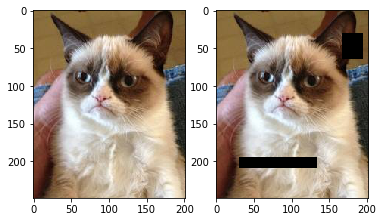

In [2]:
im = array(Image.open('grumpycat.jpeg')) / 256

# mask
h, w, _ = im.shape
omega = ones((h, w))
omega[195:209, 31:134] = 0
omega[31:65, 166:194] = 0

# create input image
omega3 = expand_dims(omega, 2)
g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(g)

## (a) Gradient Descent

In [61]:
def GetSSD(uc, im):
    m, n, *_= uc.shape
    SSD = 0
    
    for i in range(m):
        for j in range(n):
            SSD += (im[:, :, 0][i,j]-uc[:, :, 0][i,j])**2
            SSD += (im[:, :, 1][i,j]-uc[:, :, 1][i,j])**2
            SSD += (im[:, :, 2][i,j]-uc[:, :, 2][i,j])**2
            
    return SSD

In [51]:
def GetEnergy(uc, gc, omega):

    energy  = 0 
    m,n,_=uc.shape
        
    for i in range(1,m-1): 
        
        for j in range(1,n-1): 
            
            if omega[i,j]== 0:       
                              
                energy += omega[i,j]*(uc[:, :, 0][i,j]- g[:, :, 0][i,j])**2 + \
                           lmbda * ((uc[:, :, 0][i,j] - uc[:, :, 0][i-1,j])**2 + (uc[:, :, 0][i,j] - uc[:, :, 0][i,j-1])**2)
                energy += omega[i,j]*(uc[:, :, 1][i,j]- g[:, :, 1][i,j])**2 +\
                           lmbda *((uc[:, :, 1][i,j] - uc[:, :, 1][i-1,j])**2 + (uc[:, :, 1][i,j] - uc[:, :, 1][i,j-1])**2)
                energy += omega[i,j]*(uc[:, :, 2][i,j]- g[:, :, 2][i,j])**2 + \
                          lmbda *((uc[:, :, 2][i,j] - uc[:, :, 2][i-1,j])**2 + (uc[:, :, 2][i,j] - uc[:, :, 2][i,j-1])**2)
    return energy

In [3]:
def GetGradient(uc, gc, omega, lmbda):
    li, lj = uc.shape
    
    res = zeros((li, lj))

    xf1 = [[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]] 
    
    res = signal.convolve2d(uc,xf1,'same')
    
    return 2*(omega*(uc-gc) + res  * lmbda)

In [4]:
def GetD1(uc, gc, omega):
    result = (uc-gc) * omega * 2
    return result

In [5]:
def GetD2(uc, lmbda):

     li, lj = uc.shape
    
     res = zeros((li, lj))

     xf1 = [[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]] 
    
     res = signal.convolve2d(uc,xf1,'same')
    
     return res*2*lmbda

In [69]:
def GD(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    
    u = g
    E = g
    EPS = 0.07
        
    energy = zeros(1000)
    SSD = 0
    
    # separete colors
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    # inverse of the mask
    omegai = 1-omega;
    
    
    fig, axs = plt.subplots(1, 5)
   
    for i in range(1000):
        
        print(i)
        
        # calculate gradient for each color channel
        rD1 = GetD1(red,   g[:, :, 0], omega)
        gD1 = GetD1(green, g[:, :, 1], omega)
        bD1 = GetD1(blue,  g[:, :, 2], omega)
        
        rD2 = GetD2(red, lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue, lmbda)
        
        rGrad = rD1 + rD2
        gGrad = gD1 + gD2
        bGrad = bD1 + bD2
        
        # update
        red   = red   - rGrad * EPS * omegai
        green = green - gGrad * EPS * omegai
        blue  = blue  - bGrad * EPS * omegai
        
        # calculate energy       
        E[:, :, 0] = red
        E[:, :, 1] = green
        E[:, :, 2] = blue
        
        energy[i]= GetEnergy(E,g,omega)
            
        # show 5 images during the process
        if i ==1:         
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            plt.savefig('iteration1.jpg', dpi=900)
            
        #display 250th iteration
        if i == 250:
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
                        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('250th iteration')
            plt.savefig('iteration250.jpg', dpi=900)
            
        #display 500 iteration
        if i == 500:
            #plt.subplot(3, 2, 3)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('500th iteration') 
            plt.savefig('iteration500.jpg', dpi=900)
            
        #display 750 iteration
        if i == 750:
            #plt.subplot(3, 2, 4)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('750th iteration')
            plt.savefig('iteration750.jpg', dpi=900)
        
        #display 1000 iteration
        if i == 1000:
            #plt.subplot(3, 2, 5)    
            u[:, :,0] = red;
            u[:, :,1] = green;
            u[:, :,2] = blue;

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1000th iteration')
            plt.savefig('iteration1000.jpg', dpi=900)
            
    # concatenate the image
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('energyCurve.jpg')
    
    return u

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

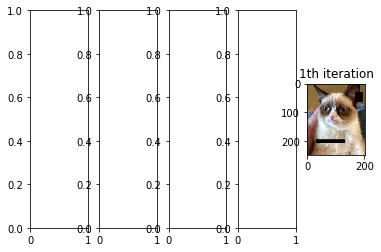

In [70]:
lmbda = 0.8  # change

uG = GD(g, omega, lmbda)

g = im * omega3

plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.savefig('original.jpg', dpi=900)
#plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')
plt.savefig('reconstructed.jpg', dpi=900)

## (b) Linearization + Gauss-Seidel

In [8]:
def Hessian_matrix(u):
    # let 'u' be the known image
    m, n, *_ = u.shape
    
    # define the coordinates of a neighborhood around each pixel 
    # (center, north, south, west, east, north-west, north-east, south-west, south-east)
    # there are 9 possible neighbors
    rows = zeros((9, m * n))
    cols = zeros((9, m * n))
    vals = zeros((9, m * n))

    for i in range(n):
        for j in range(m):
            # center pixel (i, j)
            rows[0, i * m + j] = i * m + j
            cols[0, i * m + j] = i * m + j
            if(j, i == 0):    
                vals[0, i * m + j] = 4  # here change the value (could depend on 'u')
            else:
                vals[0, i * m + j]  = 1
            
            # northern pixel (i, j - 1)
            rows[1, i * m + j] = i * m + j
            cols[1, i * m + j] = i * m + max(j - 1, 0)
            if(j, i == 0):    
                vals[1, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[1, i * m + j]  = 0
            
            # southern pixel (i, j + 1)
            rows[2, i * m + j] = i * m + j
            cols[2, i * m + j] = i * m + min(j + 1, m - 1)
            if(j, i == 0):
                vals[2, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[2, i * m + j]  = 0
            
            # western pixel  (i - 1, j)
            rows[3, i * m + j] = i * m + j
            cols[3, i * m + j] = max(i - 1, 0) * m + j
            if(j, i == 0):
                vals[3, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[3, i * m + j]  = 0
            
            # eastern pixel  (i + 1, j)
            rows[4, i * m + j] = i * m + j
            cols[4, i * m + j] = min(i + 1, n - 1) * m + j
            if(j, i == 0):
                vals[4, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[4, i * m + j]  = 0
                
            # north-western pixel (i - 1, j - 1)
            rows[5, i * m + j] = i * m + j
            cols[5, i * m + j] = max(i - 1, 0) * m + max(j - 1, 0)
            vals[5, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # north-eastern pixel (i + 1, j - 1)
            rows[6, i * m + j] = i * m + j
            cols[6, i * m + j] = min(i + 1, n - 1) * m + max(j - 1, 0)
            vals[6, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-western pixel (i - 1, j + 1)
            rows[7, i * m + j] = i * m + j
            cols[7, i * m + j] = max(i - 1, 0) * m + min(j + 1, m - 1)
            vals[7, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-eastern pixel  (i + 1, j + 1)
            rows[8, i * m + j] = i * m + j
            cols[8, i * m + j] = min(i + 1, n - 1) * m + min(j + 1, m - 1)
            vals[8, i * m + j] = 0  # here change the value (could depend on 'u')

    # generate a sparse matrix
    rows = rows.reshape(-1)
    cols = cols.reshape(-1)
    vals = vals.reshape(-1)
    A = sparse.csr_matrix((vals, (rows, cols)), shape=(n * m, n * m))
    return A

In [65]:
def LGS(g, omega, lmbda):
    
    u = g
    E = g

    omegai = 1-omega
    
    energy = zeros(1000)
    
    # separete colors
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    for i in range (1000):
        
        print(i)
        
        rD1 = GetD1(red,   g[:, :,0], omega)
        gD1 = GetD1(green, g[:, :,1], omega)
        bD1 = GetD1(blue,  g[:, :,2], omega)
        
        rD2 = GetD2(red,   lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue,  lmbda)
        
        rGrad = (rD1 + rD2) * omegai
        gGrad = (gD1 + gD2) * omegai
        bGrad = (bD1 + bD2) * omegai
            
        Ar = Hessian_matrix(red)
        Ag = Hessian_matrix(green)
        Ab = Hessian_matrix(blue)
        
        Lr = sparse.tril(Ar,0)
        Lg = sparse.tril(Ag,0)
        Lb = sparse.tril(Ab,0)
        
        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)

        rGradLin = reshape(rGrad,(size(rGrad),1))
        gGradLin = reshape(gGrad,(size(gGrad),1))
        bGradLin = reshape(bGrad,(size(bGrad),1))

        redLin   = reshape(red,  (size(red)  ,1))
        greenLin = reshape(green,(size(green),1))
        blueLin  = reshape(blue, (size(blue) ,1))
        
        br = Ar * redLin   - rGradLin
        bg = Ag * greenLin - gGradLin
        bb = Ab * blueLin  - bGradLin

        #solve for the new value of u
        redLin   = sparse.linalg.spsolve(Lr,(br - Ur * redLin))
        greenLin = sparse.linalg.spsolve(Lg,(bg - Ug * greenLin))
        blueLin  = sparse.linalg.spsolve(Lb,(bb - Ub * blueLin))

        # Rearrange the vectorize color channel and gradient in matrix form 
        red   = reshape(redLin,   (shape(g[:, :, 0])))
        green = reshape(greenLin, (shape(g[:, :, 1])))
        blue  = reshape(blueLin,  (shape(g[:, :, 2])))
        
        rGrad = reshape(rGradLin, (shape(g[:, :, 0])))
        gGrad = reshape(gGradLin, (shape(g[:, :, 1])))
        bGrad = reshape(bGradLin, (shape(g[:, :, 2])))
        
        # calculate energy       
        E[:, :, 0] = red
        E[:, :, 1] = green
        E[:, :, 2] = blue
        
        energy[i]= GetEnergy(E,g,omega)
            
        # show 5 images during the process
        if i ==1:         
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            plt.savefig('LGSiteration1.jpg', dpi=900)
            
        #display 250th iteration
        if i == 250:
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
                        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('250th iteration')
            plt.savefig('LGSiteration250.jpg', dpi=900)
            
        #display 500 iteration
        if i == 500:
            #plt.subplot(3, 2, 3)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('500th iteration') 
            plt.savefig('LGSiteration500.jpg', dpi=900)
            
        #display 750 iteration
        if i == 750:
            #plt.subplot(3, 2, 4)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('750th iteration')
            plt.savefig('LGSiteration750.jpg', dpi=900)
        
        #display 1000 iteration
        if i == 1000:
            #plt.subplot(3, 2, 5)    
            u[:, :,0] = red;
            u[:, :,1] = green;
            u[:, :,2] = blue;

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1000th iteration')
            plt.savefig('LGSiteration1000.jpg', dpi=900)
        
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('LGSenergyCurve.jpg')
    
    return u

0


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'reconstructed')

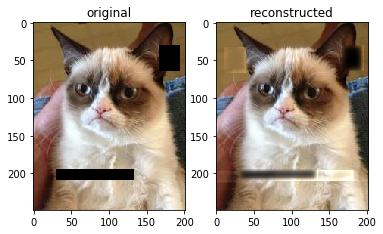

In [66]:
lmbda = 0.08  # change

g = im * omega3

uG = LGS(g, omega, lmbda)

g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.savefig('LGSoriginal.jpg', dpi=900)
plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')
plt.savefig('LGSreconstructed', dpi=900)

## (c) Linearization + SOR

In [71]:
def LSOR(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    u = g
    E = g
    
    omegai = 1 - omega
    
    energy = zeros(1000)
    
    # separate color channels:
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    # set initial guess:
    uRed   = red
    uGreen = green
    uBlue  = blue

    # Set value of w: (w>1 to speed up converging process) (0 < w < 2)
    w=1

    for i in range(1000):
        
        print(i)
        
        # Calculate gradient for each color channel:
        rD1 = GetD1(red,   g[:, :,0], omega)
        gD1 = GetD1(green, g[:, :,1], omega)
        bD1 = GetD1(blue,  g[:, :,2], omega)
        
        rD2 = GetD2(red,   lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue,  lmbda)
        
        rGrad = (rD1 + rD2) * omegai
        gGrad = (gD1 + gD2) * omegai
        bGrad = (bD1 + bD2) * omegai

        Ar = Hessian_matrix(red)
        Ag = Hessian_matrix(green)
        Ab = Hessian_matrix(blue)

        Lr = sparse.tril(Ar, 0)
        Lg = sparse.tril(Ag, 0)
        Lb = sparse.tril(Ab, 0)
        
        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)
        
        Dr = sparse.diags([Lr.diagonal()], [0])
        Dg = sparse.diags([Lg.diagonal()], [0])
        Db = sparse.diags([Lb.diagonal()], [0])
        
        DLr = Lr - Dr
        DLg = Lg - Dg
        DLb = Lb - Db
        
        rGradLin = reshape(rGrad,(size(rGrad),1))
        gGradLin = reshape(gGrad,(size(gGrad),1))
        bGradLin = reshape(bGrad,(size(bGrad),1))
        
        redLin   = reshape(red,  (size(red),1))
        greenLin = reshape(green,(size(green),1))
        blueLin  = reshape(blue, (size(blue),1))
        
        br = Ar * redLin   - rGradLin
        bg = Ag * greenLin - gGradLin
        bb = Ab * blueLin  - bGradLin
        
        
        #solve for the new value of u
        redLin   = sparse.linalg.spsolve(Dr + w * DLr,(w * br - (w * Ur + (w-1) * Dr) * redLin))
        greenLin = sparse.linalg.spsolve(Dg + w * DLg,(w * bg - (w * Ug + (w-1) * Dg) * greenLin))
        blueLin  = sparse.linalg.spsolve(Db + w * DLb,(w * bb - (w * Ub + (w-1) * Db) * blueLin))
        
        # Rearrange the vectorize color channel and gradient in matrix form 
        red   = reshape(redLin,   (shape(g[:, :, 0])))
        green = reshape(greenLin, (shape(g[:, :, 1])))
        blue  = reshape(blueLin,  (shape(g[:, :, 2])))
        
        rGrad = reshape(rGradLin, (shape(g[:, :, 0])))
        gGrad = reshape(gGradLin, (shape(g[:, :, 1])))
        bGrad = reshape(bGradLin, (shape(g[:, :, 2])))
        
        # calculate energy       
        E[:, :, 0] = red
        E[:, :, 1] = green
        E[:, :, 2] = blue
        
        energy[i]= GetEnergy(E,g,omega)
            
        # show 5 images during the process
        if i ==1:         
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            plt.savefig('LSORiteration1.jpg', dpi=900)
            
        #display 250th iteration
        if i == 250:
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
                        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('250th iteration')
            plt.savefig('LSORiteration250.jpg', dpi=900)
            
        #display 500 iteration
        if i == 500:
            #plt.subplot(3, 2, 3)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('500th iteration') 
            plt.savefig('LSORiteration500.jpg', dpi=900)
            
        #display 750 iteration
        if i == 750:
            #plt.subplot(3, 2, 4)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('750th iteration')
            plt.savefig('LSORiteration750.jpg', dpi=900)
        
        #display 1000 iteration
        if i == 1000:
            #plt.subplot(3, 2, 5)    
            u[:, :,0] = red;
            u[:, :,1] = green;
            u[:, :,2] = blue;

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1000th iteration')
            plt.savefig('LSORiteration1000.jpg', dpi=900)
        
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('LSORenergyCurve.jpg')

    return u
    

0
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
3


KeyboardInterrupt: 

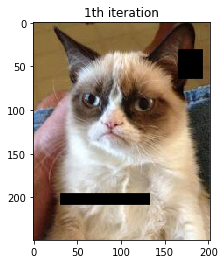

In [72]:
lmbda = 0.08  # change

g = im * omega3

uG = LSOR(g, omega, lmbda)

g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('LSORoriginal')
plt.savefig('LSORoriginal.jpg', dpi=900)
plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('LSORreconstructed')
plt.savefig('LSOreconstructed.jpg', dpi=900)